# Bipartite Graphs

In [186]:
list_of_ingredients = [1,2,3,4]
list_of_recipes = ['r1','r2','r3']
list_of_users = [1,2,3]

### Ingredient-Recipe Graph

In [187]:
import networkx as nx

ingredient_recipe = nx.Graph()
ingredient_recipe.add_nodes_from(list_of_ingredients, bipartite='ingredients')
ingredient_recipe.add_nodes_from(list_of_recipes, bipartite='recipes')

In [188]:
ing_rec_edges = [(1, "r1"), (1, "r3"), (2, "r1"), (2, "r2"), (3, "r2"), (3, "r3"), (4, "r2")]
ingredient_recipe.add_edges_from(ing_rec_edges)

In [189]:
ing_rec_pos = nx.bipartite_layout(ingredient_recipe,list_of_ingredients)

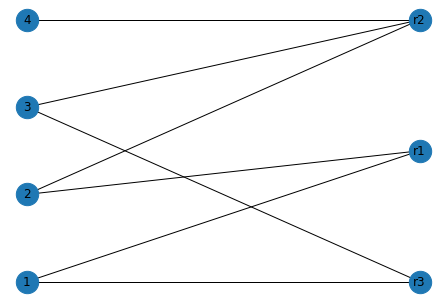

In [190]:
nx.draw(ingredient_recipe,ing_rec_pos, with_labels=1,node_size=500)

### Recipe-User

In [191]:
recipe_user = nx.Graph()
recipe_user.add_nodes_from(list_of_recipes, bipartite='recipes')
recipe_user.add_nodes_from(list_of_users, bipartite='users')

In [192]:
rec_usr_edges = [(1, "r1",5), (1, "r2", 4), (1, "r3", 4), (2, "r1",3), (2, "r2",5), (3, "r3",2)]
recipe_user.add_weighted_edges_from(rec_usr_edges)

{('r1', 1): Text(0.0, -0.375, '5'),
 ('r1', 2): Text(0.0, 0.0, '3'),
 ('r2', 1): Text(0.0, 0.0, '4'),
 ('r2', 2): Text(0.0, 0.375, '5'),
 ('r3', 1): Text(0.0, -0.75, '4'),
 ('r3', 3): Text(0.0, 0.0, '2')}

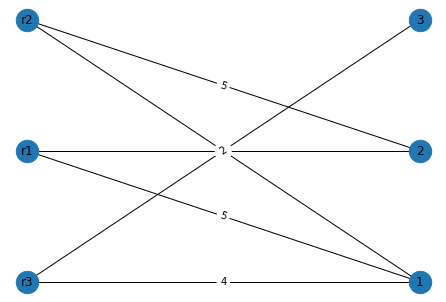

In [193]:
nx.draw(recipe_user,rec_usr_pos, with_labels=1,node_size=500)
edge_labels = nx.get_edge_attributes(recipe_user, "weight")
nx.draw_networkx_edge_labels(recipe_user, rec_usr_pos, edge_labels)

# Shallow Encoding of Ingredients

In [194]:
import numpy as np
I = np.array(list_of_ingredients)

B = ((I.reshape(-1,1) & (2**np.arange(len(list_of_ingredients).bit_length()))) != 0).astype(int)
ingredient_embeddings_matrix = B[:,::-1]
print(ingredient_embeddings_matrix)

[[0 0 1]
 [0 1 0]
 [0 1 1]
 [1 0 0]]


# GraphSAGE

### Recipe Vectors

In [195]:
recipe_vectors = []
target_user = 1
target_recipe = 'r3'

for recipe in list(recipe_user.neighbors(target_user)):
    if recipe != target_recipe:
        recipe_vector = []
        AGG = np.array([0]*len(list_of_ingredients).bit_length())
        Mean = 0
        
        for ingredient in list(ingredient_recipe.neighbors(recipe)):
            AGG += ingredient_embeddings_matrix[ingredient-1]
            
        for user in list(recipe_user.neighbors(recipe)):
            Mean += recipe_user[user][recipe]['weight']
            
        AGG = AGG/len(list(ingredient_recipe.neighbors(recipe)))                   
        Mean /= len(list(recipe_user.neighbors(recipe)))

        recipe_vector.append(list(AGG))
        recipe_vector.append(recipe_user[target_user][recipe]['weight'])
        recipe_vector.append(Mean)
        recipe_vectors.append(recipe_vector)

In [196]:
recipe_vectors

[[[0.0, 0.5, 0.5], 5, 4.0],
 [[0.3333333333333333, 0.6666666666666666, 0.3333333333333333], 4, 4.5]]

### Personalization Vector

In [197]:
personalization_vector = []
agg_recipe_vectors = np.array(recipe_vectors[0][0])
agg_target_user_ratings = recipe_vectors[0][1]
agg_recipes_other_ratings = recipe_vectors[0][2]

for i in range(len(recipe_vectors)):
    if i!= 0:
        agg_recipe_vectors += np.array(recipe_vectors[i][0])
        agg_target_user_ratings += recipe_vectors[i][1]
        agg_recipes_other_ratings += recipe_vectors[i][2]

agg_recipe_vectors /= len(recipe_vectors)
agg_target_user_ratings /= len(recipe_vectors)
agg_recipes_other_ratings /= len(recipe_vectors)

personalization_vector.append(list(agg_recipe_vectors))
personalization_vector.append(agg_target_user_ratings)
personalization_vector.append(agg_recipes_other_ratings)

In [198]:
personalization_vector

[[0.16666666666666666, 0.5833333333333333, 0.41666666666666663], 4.5, 4.25]

### Prediction

In [203]:
prediction = []

AGG = np.array([0]*len(list_of_ingredients).bit_length())
Mean = 0

for ingredient in list(ingredient_recipe.neighbors(target_recipe)):
    AGG += ingredient_embeddings_matrix[ingredient-1]
for user in list(recipe_user.neighbors(recipe)):
    if user != target_user:
        Mean += recipe_user[user][recipe]['weight']

AGG = AGG/len(list(ingredient_recipe.neighbors(target_recipe)))   
target_recipe_users = list(recipe_user.neighbors(target_recipe))
target_recipe_users.remove(target_user)
Mean /= len(target_recipe_users)

prediction.append(list(AGG))
prediction.append(personalization_vector)
prediction.append(Mean)

In [204]:
prediction

[[0.0, 0.5, 1.0],
 [[0.16666666666666666, 0.5833333333333333, 0.41666666666666663], 4.5, 4.25],
 2.0]